# Basic Matrix Factorization using sgd optimization 

In [3]:
import numpy as np
import pandas as pd

In [4]:
ratings = pd.read_csv('netflix_data.csv')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거

In [5]:
ratings

,user_id,movie_id,rating
0,2442,1,3
1,1719610,1,2
2,1011918,1,4
3,479924,1,5
4,2389367,1,1
...,...,...,...
507847,295393,4499,5
507848,305344,4499,1
507849,1627987,4499,1
507850,1988633,4499,4


In [6]:
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

## Algorithm

In [7]:
# New MF class for training & testing
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
#### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose

    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))

    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2]
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                         # Return test set

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        # Initializing user-feature and item-feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))


        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent for given number of iterations
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 5 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.P.dot(self.Q.T)


In [26]:
R_temp

movie_id,1,2,3,4,5,6,7,8,9,10,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
user_id,,,,,,,,,,,,,,,,,,,,,
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648312,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2648719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2648927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### d=5, lambda = 0.02

In [8]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=5, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result5 = mf.test()

Iteration: 5 ; Train RMSE = 3.1543 ; Test RMSE = 3.1730
Iteration: 10 ; Train RMSE = 1.6903 ; Test RMSE = 1.7335
Iteration: 15 ; Train RMSE = 1.3742 ; Test RMSE = 1.4252
Iteration: 20 ; Train RMSE = 1.2301 ; Test RMSE = 1.2859
Iteration: 25 ; Train RMSE = 1.1468 ; Test RMSE = 1.2063
Iteration: 30 ; Train RMSE = 1.0921 ; Test RMSE = 1.1546
Iteration: 35 ; Train RMSE = 1.0530 ; Test RMSE = 1.1180
Iteration: 40 ; Train RMSE = 1.0233 ; Test RMSE = 1.0906
Iteration: 45 ; Train RMSE = 0.9997 ; Test RMSE = 1.0692
Iteration: 50 ; Train RMSE = 0.9801 ; Test RMSE = 1.0518


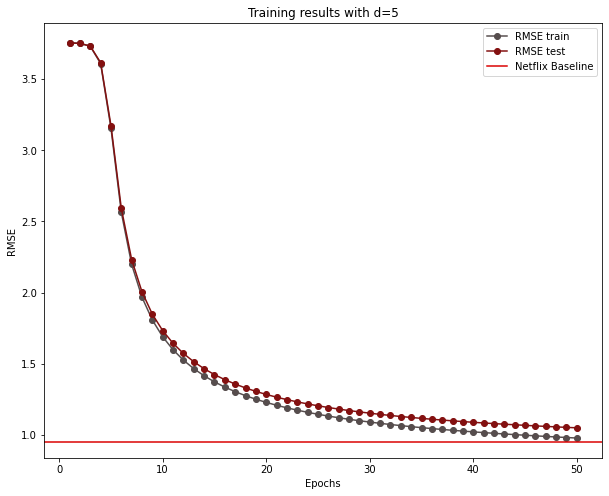

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result5)[:,0]
train_rmse_list = np.array(result5)[:,1]
test_rmse_list = np.array(result5)[:,2]

plt.title('Training results with d=5')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.02

In [10]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result10 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 3.3568 ; Test RMSE = 3.3671
Iteration: 10 ; Train RMSE = 1.7205 ; Test RMSE = 1.7592
Iteration: 15 ; Train RMSE = 1.3821 ; Test RMSE = 1.4299
Iteration: 20 ; Train RMSE = 1.2294 ; Test RMSE = 1.2835
Iteration: 25 ; Train RMSE = 1.1410 ; Test RMSE = 1.1999
Iteration: 30 ; Train RMSE = 1.0822 ; Test RMSE = 1.1457
Iteration: 35 ; Train RMSE = 1.0393 ; Test RMSE = 1.1070
Iteration: 40 ; Train RMSE = 1.0058 ; Test RMSE = 1.0777
Iteration: 45 ; Train RMSE = 0.9787 ; Test RMSE = 1.0547
Iteration: 50 ; Train RMSE = 0.9563 ; Test RMSE = 1.0366


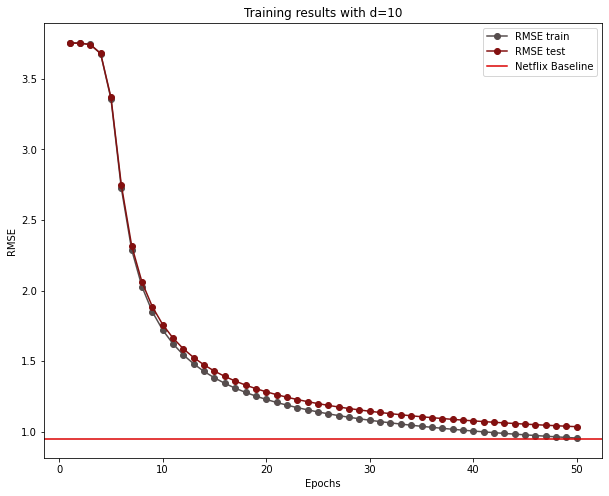

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result10)[:,0]
train_rmse_list = np.array(result10)[:,1]
test_rmse_list = np.array(result10)[:,2]

plt.title('Training results with d=10')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=20, lambda = 0.02

In [12]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result20 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 3.3830 ; Test RMSE = 3.3933
Iteration: 10 ; Train RMSE = 1.7279 ; Test RMSE = 1.7663
Iteration: 15 ; Train RMSE = 1.3884 ; Test RMSE = 1.4355
Iteration: 20 ; Train RMSE = 1.2364 ; Test RMSE = 1.2892
Iteration: 25 ; Train RMSE = 1.1485 ; Test RMSE = 1.2059
Iteration: 30 ; Train RMSE = 1.0897 ; Test RMSE = 1.1513
Iteration: 35 ; Train RMSE = 1.0465 ; Test RMSE = 1.1121
Iteration: 40 ; Train RMSE = 1.0127 ; Test RMSE = 1.0822
Iteration: 45 ; Train RMSE = 0.9852 ; Test RMSE = 1.0589
Iteration: 50 ; Train RMSE = 0.9623 ; Test RMSE = 1.0403


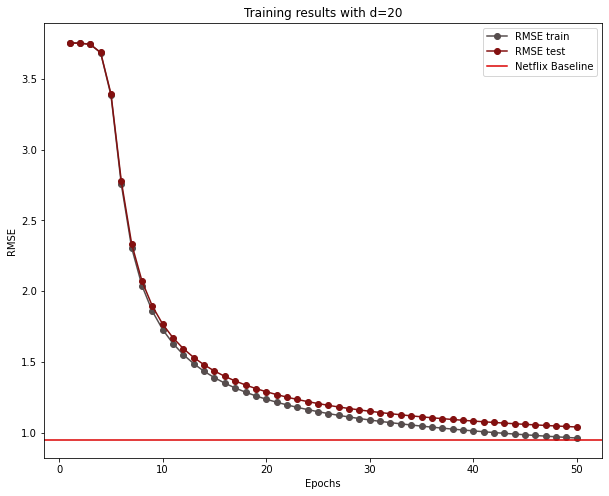

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result20)[:,0]
train_rmse_list = np.array(result20)[:,1]
test_rmse_list = np.array(result20)[:,2]

plt.title('Training results with d=20')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=30, lambda = 0.02

In [14]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result30 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 3.6100 ; Test RMSE = 3.6119
Iteration: 10 ; Train RMSE = 1.7997 ; Test RMSE = 1.8342
Iteration: 15 ; Train RMSE = 1.4143 ; Test RMSE = 1.4580
Iteration: 20 ; Train RMSE = 1.2499 ; Test RMSE = 1.2992
Iteration: 25 ; Train RMSE = 1.1566 ; Test RMSE = 1.2104
Iteration: 30 ; Train RMSE = 1.0949 ; Test RMSE = 1.1528
Iteration: 35 ; Train RMSE = 1.0494 ; Test RMSE = 1.1117
Iteration: 40 ; Train RMSE = 1.0134 ; Test RMSE = 1.0802
Iteration: 45 ; Train RMSE = 0.9840 ; Test RMSE = 1.0554
Iteration: 50 ; Train RMSE = 0.9595 ; Test RMSE = 1.0358


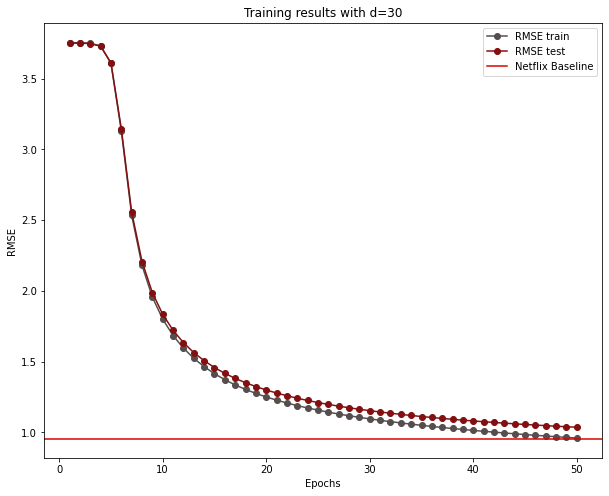

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result30)[:,0]
train_rmse_list = np.array(result30)[:,1]
test_rmse_list = np.array(result30)[:,2]

plt.title('Training results with d=30')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=40, lambda = 0.02

In [16]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=40, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)

import time
start = time.time()
result40 = mf.test()
print(time.time()-start)

Iteration: 5 ; Train RMSE = 3.5873 ; Test RMSE = 3.5898
Iteration: 10 ; Train RMSE = 1.7890 ; Test RMSE = 1.8235
Iteration: 15 ; Train RMSE = 1.4115 ; Test RMSE = 1.4547
Iteration: 20 ; Train RMSE = 1.2499 ; Test RMSE = 1.2985
Iteration: 25 ; Train RMSE = 1.1585 ; Test RMSE = 1.2111
Iteration: 30 ; Train RMSE = 1.0983 ; Test RMSE = 1.1546
Iteration: 35 ; Train RMSE = 1.0543 ; Test RMSE = 1.1142
Iteration: 40 ; Train RMSE = 1.0196 ; Test RMSE = 1.0834
Iteration: 45 ; Train RMSE = 0.9909 ; Test RMSE = 1.0588
Iteration: 50 ; Train RMSE = 0.9668 ; Test RMSE = 1.0391


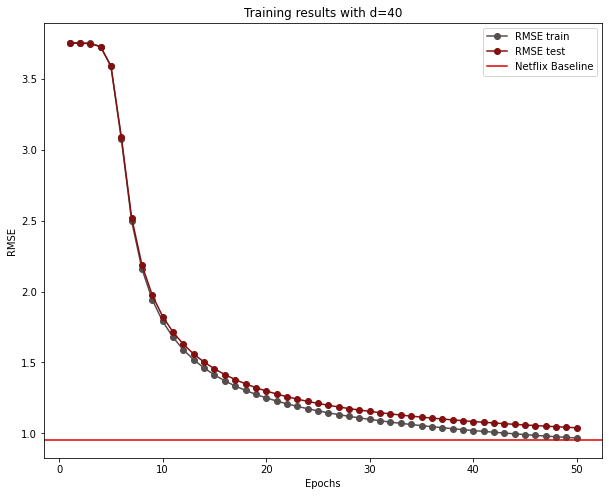

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result40)[:,0]
train_rmse_list = np.array(result40)[:,1]
test_rmse_list = np.array(result40)[:,2]

plt.title('Training results with d=40')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=50, lambda = 0.02

In [18]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=50, alpha=0.001, beta=0.02, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result50 = mf.test()

Iteration: 5 ; Train RMSE = 3.6222 ; Test RMSE = 3.6235
Iteration: 10 ; Train RMSE = 1.8062 ; Test RMSE = 1.8401
Iteration: 15 ; Train RMSE = 1.4171 ; Test RMSE = 1.4599
Iteration: 20 ; Train RMSE = 1.2525 ; Test RMSE = 1.3007
Iteration: 25 ; Train RMSE = 1.1599 ; Test RMSE = 1.2121
Iteration: 30 ; Train RMSE = 1.0991 ; Test RMSE = 1.1552
Iteration: 35 ; Train RMSE = 1.0550 ; Test RMSE = 1.1145
Iteration: 40 ; Train RMSE = 1.0203 ; Test RMSE = 1.0837
Iteration: 45 ; Train RMSE = 0.9917 ; Test RMSE = 1.0590
Iteration: 50 ; Train RMSE = 0.9674 ; Test RMSE = 1.0391


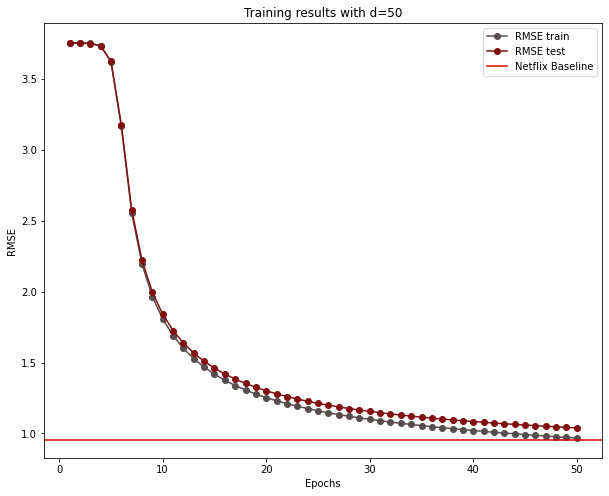

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result50)[:,0]
train_rmse_list = np.array(result50)[:,1]
test_rmse_list = np.array(result50)[:,2]

plt.title('Training results with d=50')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.01

In [20]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.01, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result01 = mf.test()

Iteration: 5 ; Train RMSE = 3.3959 ; Test RMSE = 3.4064
Iteration: 10 ; Train RMSE = 1.7309 ; Test RMSE = 1.7701
Iteration: 15 ; Train RMSE = 1.3885 ; Test RMSE = 1.4361
Iteration: 20 ; Train RMSE = 1.2352 ; Test RMSE = 1.2888
Iteration: 25 ; Train RMSE = 1.1464 ; Test RMSE = 1.2051
Iteration: 30 ; Train RMSE = 1.0873 ; Test RMSE = 1.1505
Iteration: 35 ; Train RMSE = 1.0439 ; Test RMSE = 1.1117
Iteration: 40 ; Train RMSE = 1.0097 ; Test RMSE = 1.0825
Iteration: 45 ; Train RMSE = 0.9813 ; Test RMSE = 1.0594
Iteration: 50 ; Train RMSE = 0.9571 ; Test RMSE = 1.0408


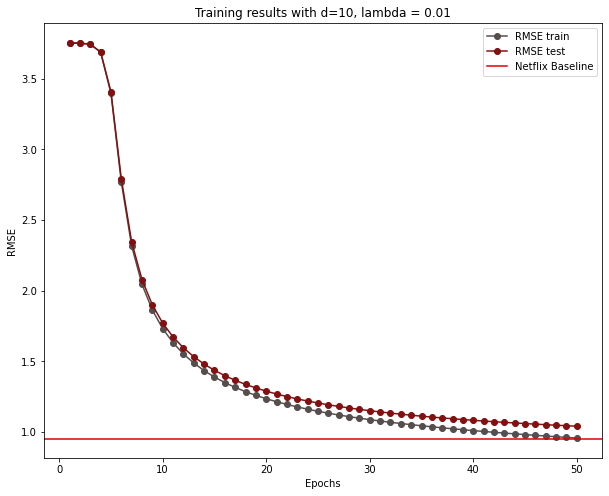

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result01)[:,0]
train_rmse_list = np.array(result01)[:,1]
test_rmse_list = np.array(result01)[:,2]

plt.title('Training results with d=10, lambda = 0.01')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.05

In [22]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.05, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result05 = mf.test()

Iteration: 5 ; Train RMSE = 3.5194 ; Test RMSE = 3.5258
Iteration: 10 ; Train RMSE = 1.7689 ; Test RMSE = 1.8063
Iteration: 15 ; Train RMSE = 1.4027 ; Test RMSE = 1.4491
Iteration: 20 ; Train RMSE = 1.2446 ; Test RMSE = 1.2964
Iteration: 25 ; Train RMSE = 1.1552 ; Test RMSE = 1.2110
Iteration: 30 ; Train RMSE = 1.0979 ; Test RMSE = 1.1568
Iteration: 35 ; Train RMSE = 1.0572 ; Test RMSE = 1.1185
Iteration: 40 ; Train RMSE = 1.0267 ; Test RMSE = 1.0903
Iteration: 45 ; Train RMSE = 1.0023 ; Test RMSE = 1.0680
Iteration: 50 ; Train RMSE = 0.9821 ; Test RMSE = 1.0499


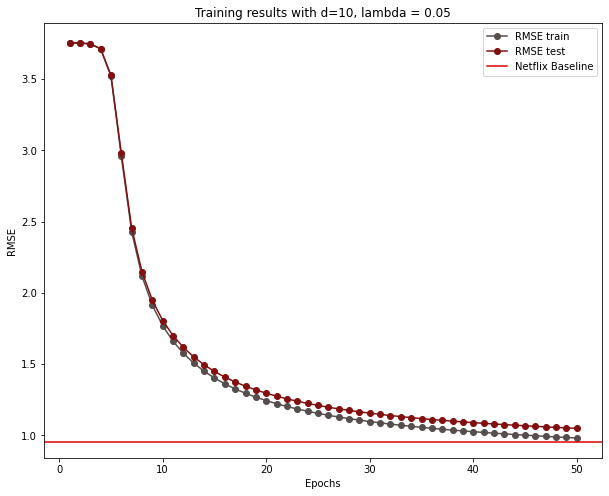

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result05)[:,0]
train_rmse_list = np.array(result05)[:,1]
test_rmse_list = np.array(result05)[:,2]

plt.title('Training results with d=10, lambda = 0.05')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

### d=10, lambda = 0.1

In [24]:
# Testing MF RMSE
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=10, alpha=0.001, beta=0.1, iterations=50, verbose=True)
test_set = mf.set_test(ratings_test)
result_1 = mf.test()

Iteration: 5 ; Train RMSE = 3.5084 ; Test RMSE = 3.5141
Iteration: 10 ; Train RMSE = 1.7802 ; Test RMSE = 1.8167
Iteration: 15 ; Train RMSE = 1.4128 ; Test RMSE = 1.4583
Iteration: 20 ; Train RMSE = 1.2539 ; Test RMSE = 1.3046
Iteration: 25 ; Train RMSE = 1.1647 ; Test RMSE = 1.2190
Iteration: 30 ; Train RMSE = 1.1069 ; Test RMSE = 1.1639
Iteration: 35 ; Train RMSE = 1.0669 ; Test RMSE = 1.1256
Iteration: 40 ; Train RMSE = 1.0369 ; Test RMSE = 1.0971
Iteration: 45 ; Train RMSE = 1.0144 ; Test RMSE = 1.0757
Iteration: 50 ; Train RMSE = 0.9958 ; Test RMSE = 1.0579


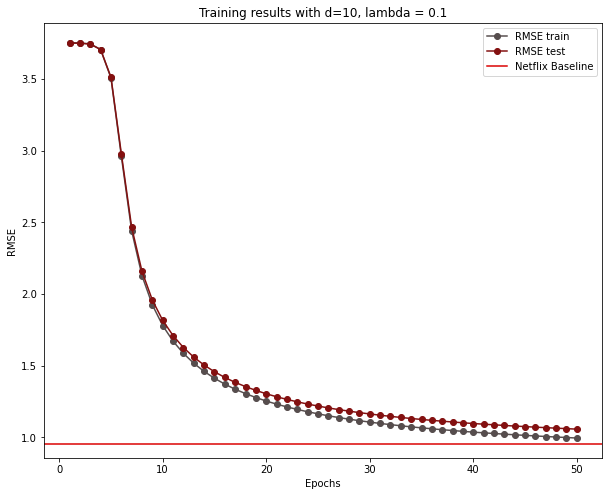

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
train_epoch_list = np.array(result_1)[:,0]
train_rmse_list = np.array(result_1)[:,1]
test_rmse_list = np.array(result_1)[:,2]

plt.title('Training results with d=10, lambda = 0.1')
plt.plot(train_epoch_list, train_rmse_list, label='RMSE train', 
         color='#564d4d', marker='o', linestyle='-')
plt.plot(train_epoch_list, test_rmse_list, label='RMSE test', 
         color='#831010', marker='o')
plt.axhline(0.9514, color='#db0000', label='Netflix Baseline')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()